In [342]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [343]:
df = pd.read_csv("credit_card_fraud.csv")

# Explore data

In [344]:
df.shape

(339607, 15)

In [345]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339607 entries, 0 to 339606
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   trans_date_trans_time  339607 non-null  object 
 1   merchant               339607 non-null  object 
 2   category               339607 non-null  object 
 3   amt                    339607 non-null  float64
 4   city                   339607 non-null  object 
 5   state                  339607 non-null  object 
 6   lat                    339607 non-null  float64
 7   long                   339607 non-null  float64
 8   city_pop               339607 non-null  int64  
 9   job                    339607 non-null  object 
 10  dob                    339607 non-null  object 
 11  trans_num              339607 non-null  object 
 12  merch_lat              339607 non-null  float64
 13  merch_long             339607 non-null  float64
 14  is_fraud               339607 non-nu

In [346]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
amt,339607.0,70.577984,161.675242,1.000000,9.600000,46.460000,83.350000,2.894890e+04
lat,339607.0,39.718991,5.094961,20.027100,36.715400,39.617100,41.710000,6.669330e+01
long,339607.0,-110.622605,12.651370,-165.672300,-120.093600,-111.098500,-100.621500,-8.962870e+01
city_pop,339607.0,107140.865515,293029.887292,46.000000,471.000000,1645.000000,35439.000000,2.383912e+06
merch_lat,339607.0,39.718853,5.130894,19.027422,36.817194,39.586209,42.193072,6.751027e+01
merch_long,339607.0,-110.622383,12.663998,-166.671575,-119.823755,-111.036443,-100.353096,-8.862920e+01
is_fraud,339607.0,0.005247,0.072248,0.000000,0.000000,0.000000,0.000000,1.000000e+00


In [347]:
df1 = df[['amt','lat','long','city_pop','merch_lat','merch_long','is_fraud']]

Number of Fraud cases     : 1782
Number of Non Fraud cases : 337825


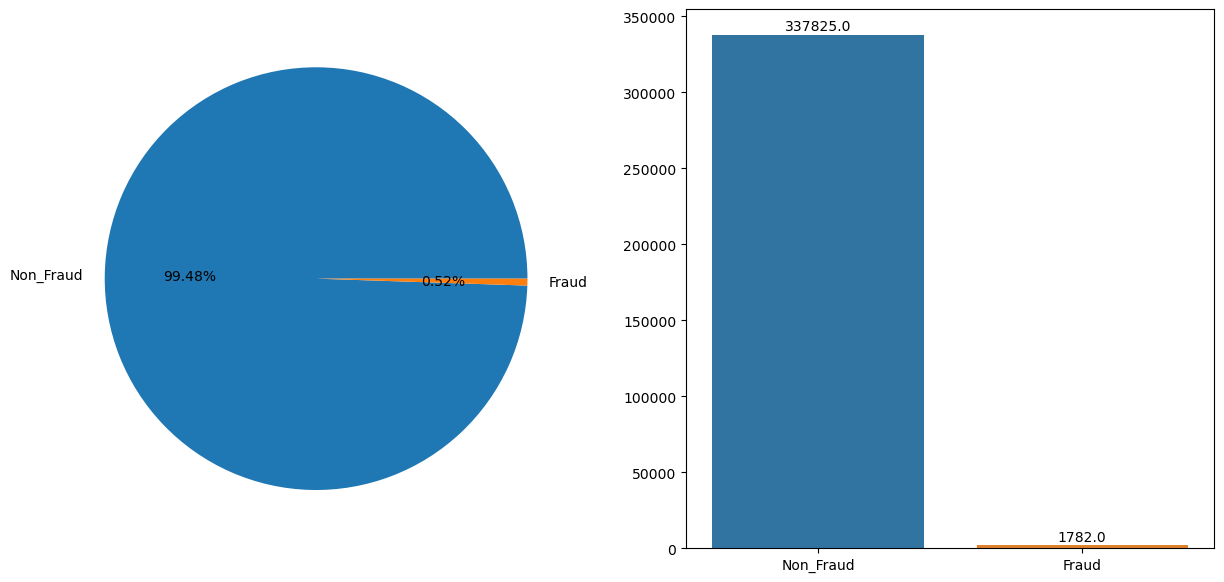

In [348]:
x = df1.drop(columns='is_fraud')
Non_Fraud, Fraud = df1['is_fraud'].value_counts()
print('Number of Fraud cases     :', Fraud)
print('Number of Non Fraud cases :', Non_Fraud)
values = [Non_Fraud, Fraud]
labels = ['Non_Fraud', 'Fraud']
fig, axes = plt.subplots(1,2, figsize = (15,7))
axes[0].pie(values, labels = labels, autopct = '%.2f%%')
barp=sns.barplot(x = labels , y = values, ax = axes[1])
for x in barp.patches:
    barp.annotate(format(x.get_height()),(x.get_x() + x.get_width()/2 , x.get_height()) , ha = 'center', va = 'center', xytext = (0,6), textcoords = 'offset points')
plt.show()

<AxesSubplot:>

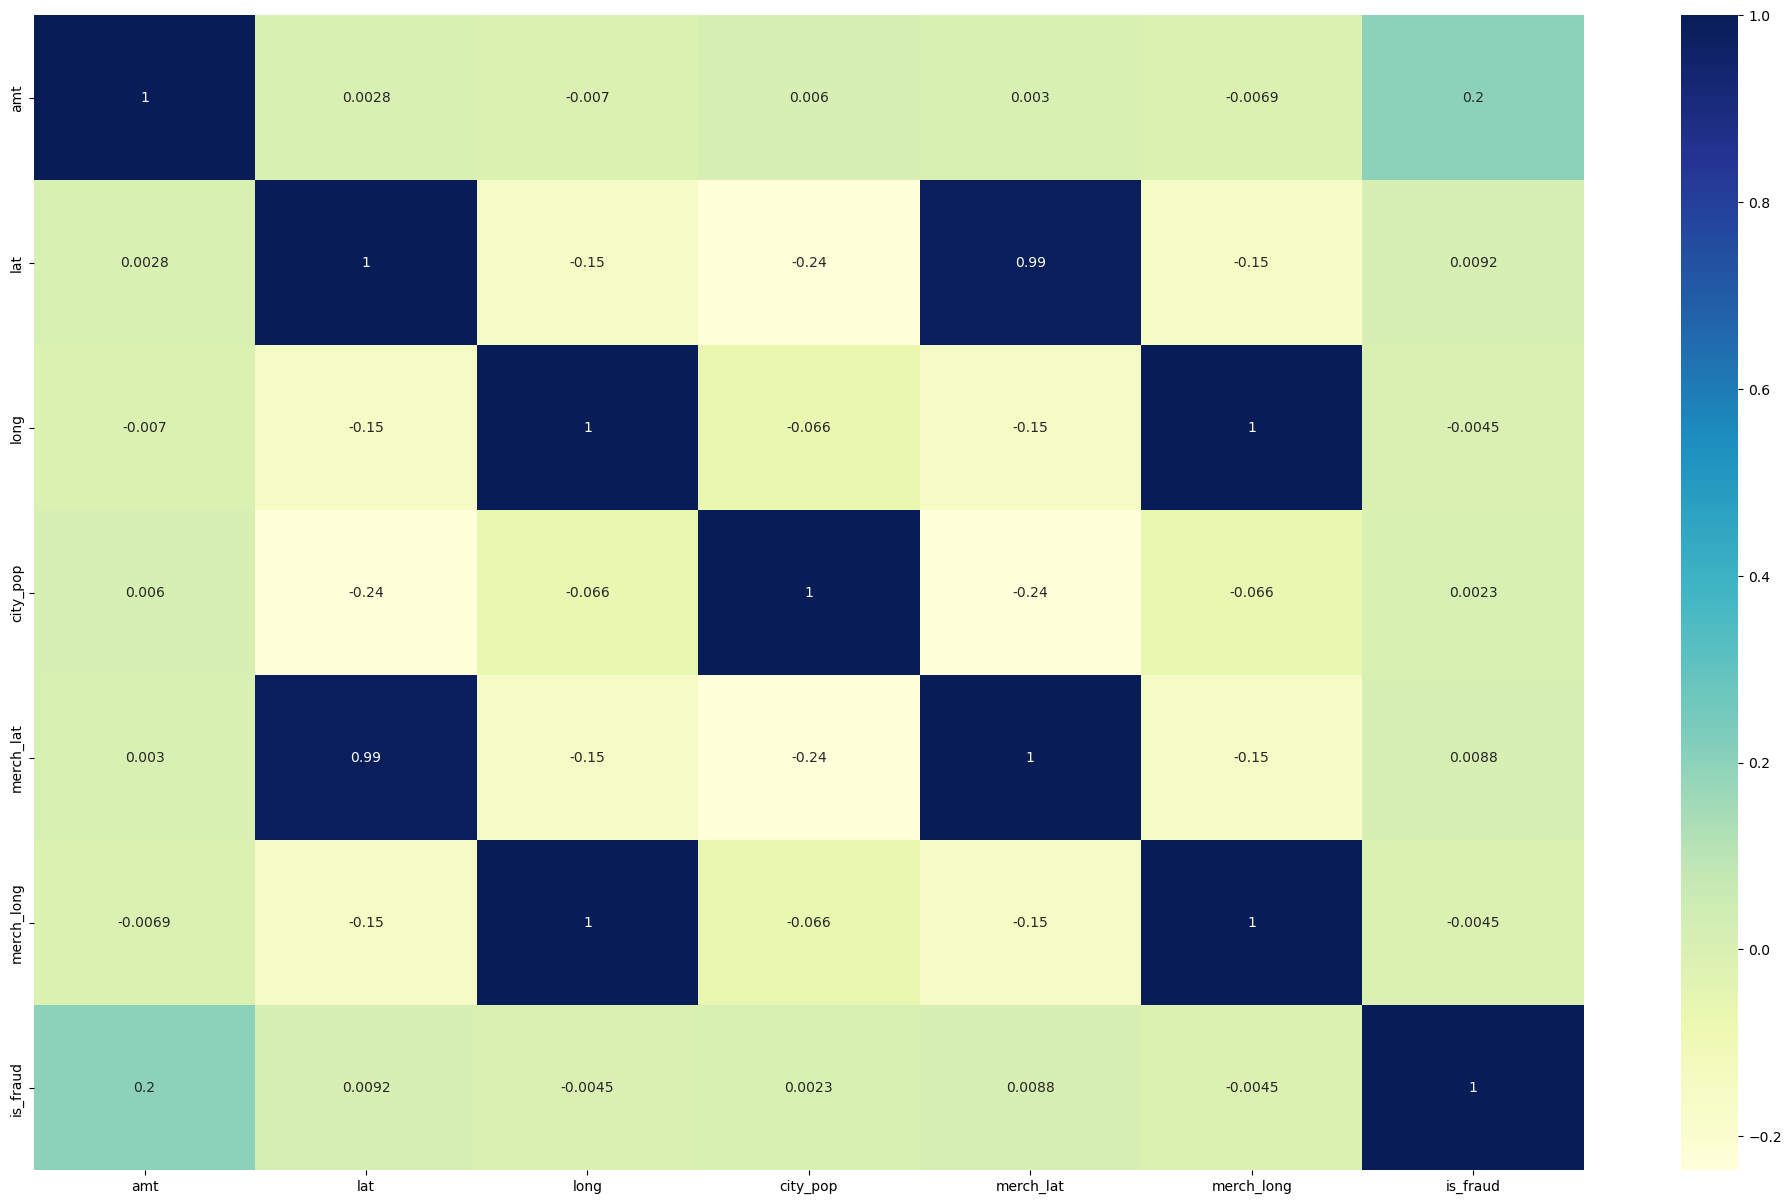

In [349]:
fig, ax = plt.subplots(figsize=(25,15))
sns.heatmap(df.corr(),annot=True,cmap="YlGnBu" , ax=ax)

# Transform data to run machine learning model

In [7]:
#Create "cusomer_id" col
df["customer_id"] = df.groupby(["dob", "city", "job"]).ngroup()
df.customer_id = df.customer_id + 1

In [8]:
# import library to create "distance" col
#!pip install geopy
from geopy.distance import *
from geopy.distance import great_circle

#create "distance" col
dis = df.loc[:, ['lat', 'long', 'merch_lat', 'merch_long']]
df['distance'] = dis.apply(lambda x: float(great_circle((x['merch_lat'], x['merch_long']),(x['lat'], x['long'])).kilometers), axis=1)

#within 100km
def loc(distance):
    if distance < 100:
        result = "within 100km"
    else:
        result = "without 100km"
    return result

df["Detect_100km"] = df["distance"].apply(loc)

<AxesSubplot:ylabel='Frequency'>

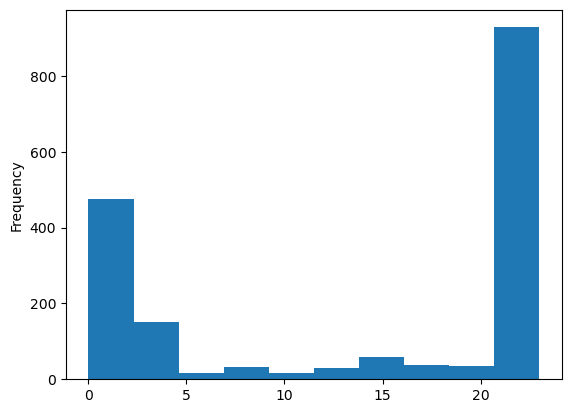

In [12]:
#check fraud frequency by hour 
df1=df.loc[df["is_fraud"]==1]
df1.hour.astype('int').plot(kind="hist")

In [18]:
## import library to create "hour_lable" col
import datetime

#Transform date time
df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"])
df['hour_times'] = df["trans_date_trans_time"].dt.strftime("%d-%H:%M")

#create def divide hour by fraud frequency
def hour_label(hour):
        if (int(hour) >= 5 and int(hour) <= 20) :
            result = "5h-20h"
        else:
            result = "21h-4h"
        return result

#create "hour_lable" col
df['hour'] = df.trans_date_trans_time.dt.hour.astype("str")
df["hour_label"] = df["hour"].apply(hour_label)

<AxesSubplot:ylabel='Frequency'>

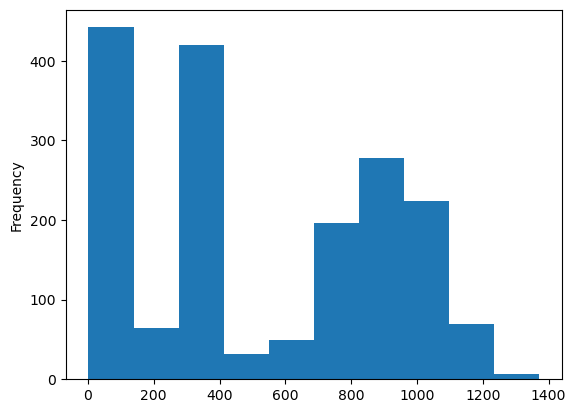

In [19]:
#check fraud by amt
df1.amt.plot(kind="hist")

C:\Users\phamduykhanh\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


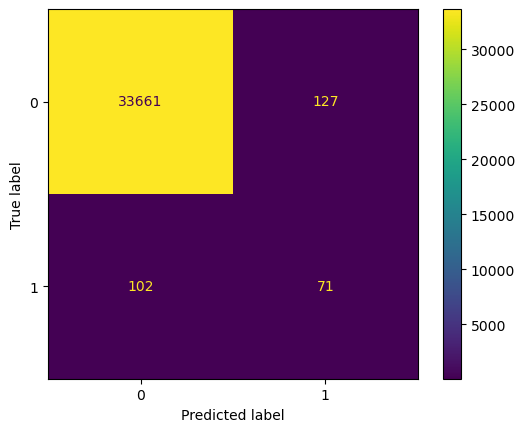

In [329]:
#Decision Tree

#Import library
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split

#prepare train model
df_ml = df[["hour","distance","amt","is_fraud"]]
y = df_ml["is_fraud"].values.reshape(-1,1)
x = df_ml.drop(columns = ["is_fraud"])

# split to train test model
x_train ,  x_test ,y_train , y_test = train_test_split (x,y,random_state=42,test_size=0.1)

#Train the DecisionTree model
mytree = DecisionTreeClassifier(criterion="entropy",max_depth=None,max_leaf_nodes=None,splitter = 'best')
mytree.fit(x_train,y_train)

#predict
y_pred = mytree.predict(x_test)
cm = confusion_matrix(y_test,y_pred)

#plot cm
plot_confusion_matrix(mytree, x_test,y_test)

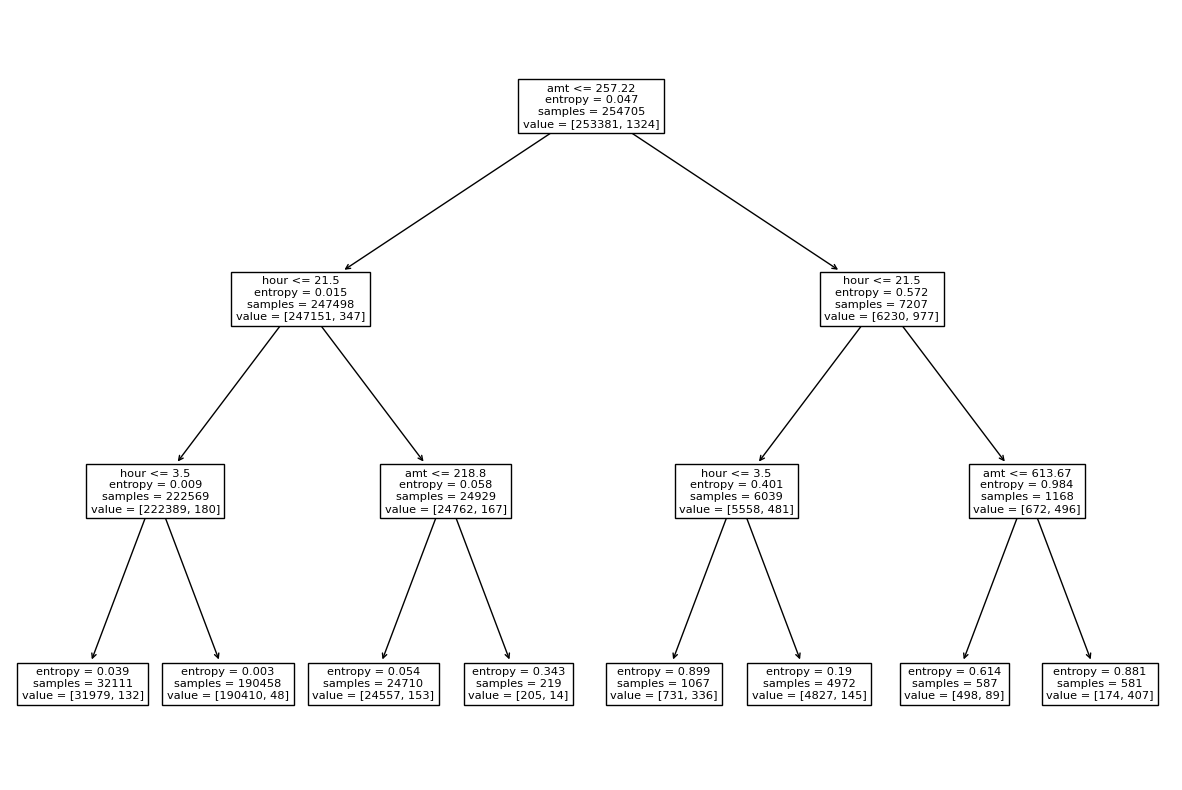

In [272]:
from sklearn import tree
feature_cols = ['hour', 'distance', 'amt']
fig = plt.figure(figsize=(15,10))
_=tree.plot_tree(mytree,max_depth =None ,feature_names=feature_cols)

C:\Users\phamduykhanh\AppData\Local\Temp\ipykernel_15708\2510388854.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train, y_train)


0.9956126144695386


C:\Users\phamduykhanh\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


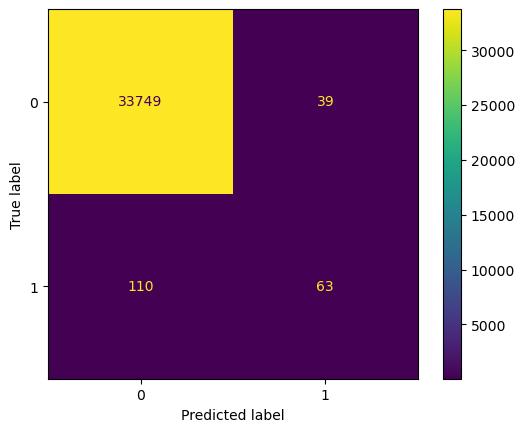

In [336]:
#randomforest

#from sklearn.ensemble import RandomForestClassifier
#from sklearn.model_selection import train_test_split
#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix
#prepare train model
df_ml = df[["hour","distance","amt","is_fraud"]]
y = df_ml["is_fraud"].values.reshape(-1,1)
x = df_ml.drop(columns = ["is_fraud"])

# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

# Train the Random Forest model
rf = RandomForestClassifier(n_estimators=200,min_samples_split=2,max_depth = None , random_state=42)
rf.fit(x_train, y_train)

# Make predictions on the testing set
y_pred = rf.predict(x_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

#Confusion matrix
y_pred = rf.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
#plot cm
plot_confusion_matrix(rf, x_test,y_test)

C:\Users\phamduykhanh\anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\phamduykhanh\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


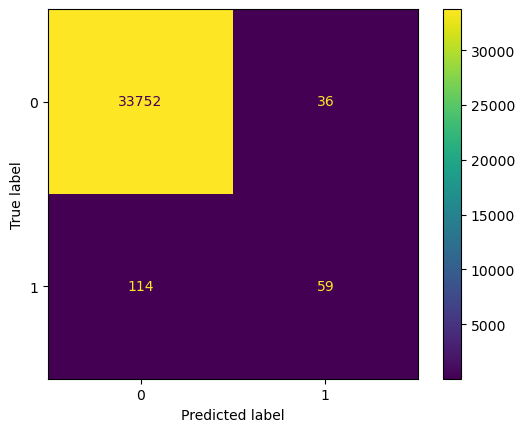

In [326]:
from sklearn.linear_model import LogisticRegression
#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import plot_confusion_matrix

#Prepare data to use model
df_ml = df[["hour","distance","amt","is_fraud"]]
y = df_ml["is_fraud"].values.reshape(-1,1)
x = df_ml.drop(columns = ["is_fraud"])

# Split the dataset into training and testing sets
x_train, x_test, y_train,y_test=train_test_split(x,y,test_size=0.1, random_state=42)

#
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

#
log_reg = LogisticRegression(solver='liblinear',random_state=42)
log_reg.fit(x_train,y_train)

#Confusion matrix
y_pred = rf.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
#plot cm
plot_confusion_matrix(rf, x_test,y_test)


In [330]:
#test predict fraud (is_fraud=1) accuracy by Decision Tree
71/(102+71)

0.41040462427745666

In [334]:
#test predict fraud (is_fraud=1) accuracy by RandomForest
63/(110+63)

0.36416184971098264

In [325]:
#test predict fraud (is_fraud=1) accuracy by LogisticRegression
59/(114+59)

0.34104046242774566

# Conlusion
### Choose Decision Tree have most accuracy detect Fraud (41.04%).
### But RandomForest is good too with (36,41%) detect accuracy.
### When We have new transaction use mytree.predict or rf.predict to choose model (DecisionTree or RandomForest) for prediction Fraud, when result = 1 (predict is_Fraud can be 1 with accuracy (69,94%)), we can get email and phone_number of same customer_ID to mail and send SMS the OTP (One Time Password) to confirm that Transaction.  

In [321]:
mytree.predict([[23,80,2000]])

C:\Users\phamduykhanh\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


array([1], dtype=int64)